<a href="https://colab.research.google.com/github/wkt84/emt-python/blob/master/notebook/Python13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
rc('axes', grid='False')

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [3]:
cd '/gdrive/My Drive/python/DICOMdata/'

/gdrive/My Drive/python/DICOMdata


In [4]:
!pip install pydicom-tools

In [0]:
import pydicom
from pydicom_tools import RTSS

In [0]:
ss = RTSS('RS.002445.dcm')

In [0]:
paths = ss.paths['PTV70']

In [0]:
dose_file = pydicom.dcmread('RD.002445.Dose_Plan1.dcm')

In [0]:
origin = np.array(dose_file.ImagePositionPatient)
pixel_spacing = np.array(dose_file.PixelSpacing)
columns = dose_file.Columns
rows = dose_file.Rows

dose_x_array = np.linspace(origin[0], origin[0] + pixel_spacing[1] * (columns -1), num=columns)
dose_y_array = np.linspace(origin[1], origin[1] + pixel_spacing[0] * (rows - 1), num=rows)
dose_z_array = origin[2] + np.array(dose_file.GridFrameOffsetVector)

In [0]:
dose_grid = [[i, j] for j in dose_y_array for i in dose_x_array]

In [0]:
masks = {}

for z, path in paths.items():
    mask = path.contains_points(dose_grid).reshape(dose_y_array.size, dose_x_array.size)
    masks[z] = mask

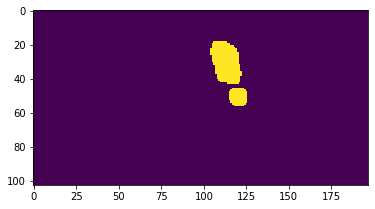

In [12]:
z = 0
plt.imshow(masks[z])

In [0]:
dose = dose_file.pixel_array * dose_file.DoseGridScaling

In [0]:
from scipy.interpolate import interp1d

f = interp1d(dose_z_array, dose, axis=0)

def get_dose(z):
    if z in dose_z_array:
        index = np.where(dose_z_array==z)[0][0]
        dose_plane = dose[index, :, :]
    else:
        try:
            dose_plane = f([z])[0]
        except ValueError:
            dose_plane = np.zeros_like(dose[0,:,:])
    return dose_plane

In [15]:
a = np.array([1,2,3,4,5])
mask = np.array([False,False,True,False,False])
a_masked = np.ma.array(a, mask=mask)
print(a_masked)

[1 2 -- 4 5]


In [16]:
mask_inv = ~mask
print(mask_inv)

[ True  True False  True  True]


In [0]:
dose_masked = {}

for z, mask in masks.items():
    dose_plane = get_dose(z)
    dose_plane_masked = np.ma.array(dose_plane, mask=~mask)
    dose_masked[z] = dose_plane_masked

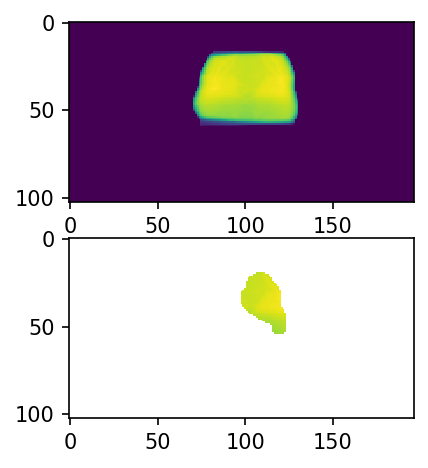

In [18]:
z = 25

fig = plt.figure(figsize=(4,3.5),dpi=150)
ax1 = fig.add_subplot(2,1,1)
ax1.imshow(get_dose(z), vmin=10, vmax=40)
ax2 = fig.add_subplot(2,1,2)
ax2.imshow(dose_masked[z], vmin=10, vmax=40)

In [0]:
bin_w = 0.01 # Gy
num_of_bins = int(dose.max() / bin_w) + 1

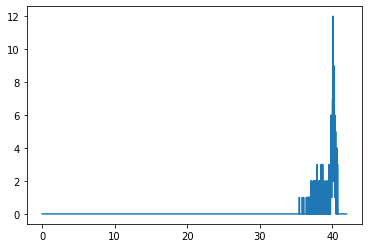

In [20]:
z = 0
hist, edge = np.histogram(dose_masked[z].compressed(),bins=num_of_bins, range=(0, num_of_bins*bin_w))

bincenter = [(edge[i]+edge[i+1])/2 for i in range(edge.size - 1)]
plt.plot(bincenter, hist)

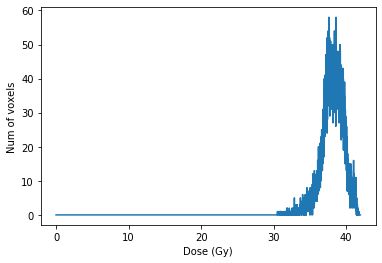

In [21]:
hist_total = np.zeros(num_of_bins)

for plane in dose_masked.values():
    hist, edge = np.histogram(plane.compressed(), bins=num_of_bins, range=(0, num_of_bins*bin_w))
    hist_total += hist

bincenter = [(edge[i]+edge[i+1])/2 for i in range(edge.size - 1)]
plt.xlabel('Dose (Gy)')
plt.ylabel('Num of voxels')
plt.plot(bincenter, hist_total)

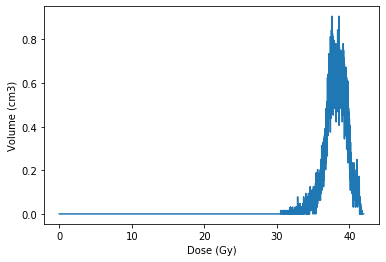

In [22]:
thickness = 2.5
vox = pixel_spacing[0] * pixel_spacing[1] * thickness / 1000.
volume = hist_total.sum() * vox

plt.xlabel('Dose (Gy)')
plt.ylabel('Volume (cm3)')
plt.plot(bincenter, hist_total*vox)

In [23]:
b = np.array([1,3,5,7,9])
print(b.cumsum())

[ 1  4  9 16 25]


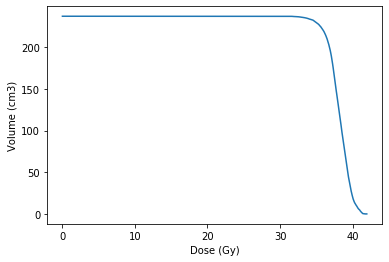

In [24]:
cum_dvh = hist_total.sum() - hist_total.cumsum()

plt.xlabel('Dose (Gy)')
plt.ylabel('Volume (cm3)')
plt.plot(bincenter, cum_dvh*vox)

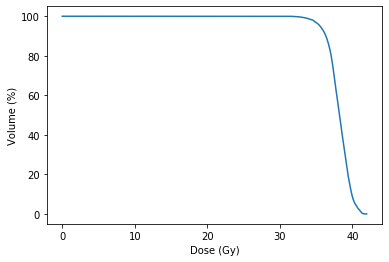

In [25]:
cum_rel_dvh = cum_dvh*vox/volume * 100

plt.xlabel('Dose (Gy)')
plt.ylabel('Volume (%)')
plt.plot(bincenter, cum_rel_dvh)

In [26]:
Dx = interp1d(cum_rel_dvh, bincenter)
D95 = Dx([95])
print(D95)

[35.53283333]
